In [1]:
%pylab inline
import pandas as pd
import grispy as gsp
import healpy as hp 
import programas as pg

Populating the interactive namespace from numpy and matplotlib


In [2]:
def perfil_interpolado(x,y,z,bineado,rvoid,field,bin_size):
    
    ngrid = field.shape[0]
    puntos = 80
    perfil = np.zeros(bineado.shape[0] - 1)
    
    i = 0
    for radio in bineado[1:]:
        puntos = numero_de_puntos(radio)
        posx, posy, posz = pg.fibo_points(x,y,z,radio*rvoid,puntos,ngrid)
        
        field_count = []
        for j in range(puntos):
            
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            
            field_value = pg.interpolador(px,py,pz,field,bin_size)
            field_count.append(field_value)
            
        perfil[i] = np.mean(field_count)
        i = i + 1
        
    return perfil

In [3]:
def numero_de_puntos(distance):
    nmin = 30
    if distance < 1:
        p = nmin
    if distance >= 1:    
        p = int(nmin*distance**2)
        
    return p

In [4]:
field = np.load('/mnt/projects/bias_mock/rhogal_eul_bias_gaus.npy')
v = np.loadtxt('sphvds_raul-0.8.dat')

In [5]:
nbines = 20 
rmin = 0
rmax = 3
bineado = np.linspace(rmin,rmax,nbines+1)

rhomean = np.mean(field)
ngrid = field.shape[0]
lbox = 1440
bin_size = lbox/ngrid

In [6]:
id_void = 6

x = v[id_void,2]
y = v[id_void,3]
z = v[id_void,4]
rvoid = v[id_void,1]

print('rvoid:',rvoid)

rvoid: 16.19412994384766


In [7]:
%%time
perfil = perfil_interpolado(x,y,z,bineado,rvoid,field,bin_size)

CPU times: user 53.7 ms, sys: 387 µs, total: 54.1 ms
Wall time: 53.7 ms


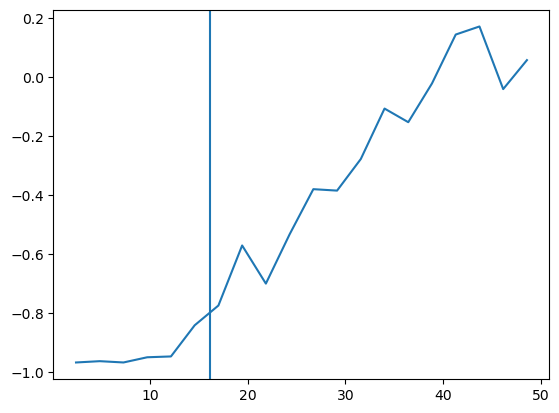

In [8]:
plt.plot(bineado[1:]*rvoid, (perfil-rhomean)/rhomean)
plt.axvline(x = rvoid)

In [13]:
import numpy as np
from joblib import Parallel, delayed

def calcular_perfiles(id_void):
    x = v[id_void, 2]
    y = v[id_void, 3]
    z = v[id_void, 4]
    rvoid = v[id_void, 1]
    return perfil_interpolado(x, y, z, bineado, rvoid, field, bin_size)

In [34]:
%%time
if __name__ == "__main__":
    num_procesos = 4  # Puedes ajustar este número según tu hardware
    
    id_voids = range(100)
    perfiles = Parallel(n_jobs=num_procesos)(delayed(calcular_perfiles)(id_void) for id_void in id_voids)
    
    perfiles = np.array(perfiles)

CPU times: user 195 ms, sys: 463 ms, total: 659 ms
Wall time: 20.1 s


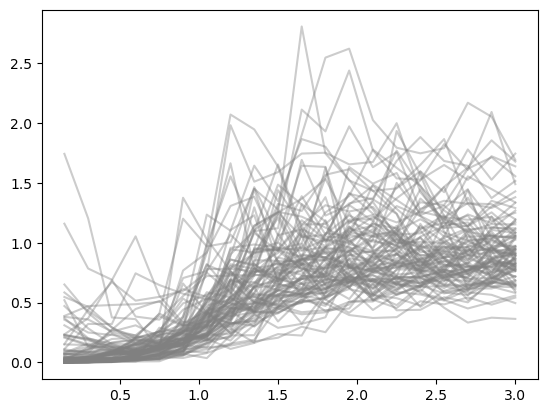

In [35]:
for i in range(100):
    plt.plot(bineado[1:],perfiles[i,:],color='grey',alpha=.4)

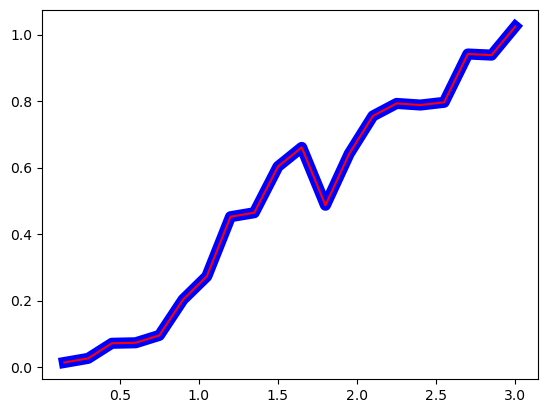

In [36]:
id_void = 4

x = v[id_void,2]
y = v[id_void,3]
z = v[id_void,4]
rvoid = v[id_void,1]

perfil = perfil_interpolado(x,y,z,bineado,rvoid,field,bin_size)
plt.plot(bineado[1:],perfil,color='blue',lw=8)

plt.plot(bineado[1:],perfiles[id_void,:],color='red',alpha=1)

In [37]:
m,q1,q2 = pg.median_profile(perfiles.T,25,75)

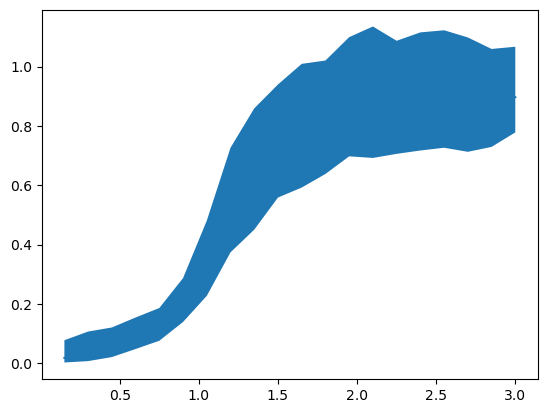

In [38]:
plt.plot(bineado[1:],m)
plt.fill_between(bineado[1:],q1,q2)